## Github Time to Merge Log Models

In this notebook we build upon the previous work of time to merge models of openshift-origin PRs. Namely, instead of treating it as a classification problem, we will instead solve the regression problem by doing a log transform. This is motivated by the philosophical fact that simpler is usually better, and a regression problem such as predicting a continous output (i.e. time to merge) could best be solved by training a model to predict a continous output. A regression model can take into account how close things are to each other, and understand variances better than a classification model. We will try to replicate the previous methods as closely as possible in order to do a legitimate comparison of which method works better.

In [1]:
import os
import sys

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score, mean_squared_error

from dotenv import load_dotenv, find_dotenv

metric_template_path = "../data-sources/TestGrid/metrics"
if metric_template_path not in sys.path:
    sys.path.insert(1, metric_template_path)

metric_template_path = "../data-sources/oc-github-repo/"
if metric_template_path not in sys.path:
    sys.path.insert(1, metric_template_path)

from ipynb.fs.defs.metric_template import (  # noqa: E402
    CephCommunication,  # noqa: E402
)  # noqa: E402

from ipynb.fs.defs.github_PR_EDA import (  # noqa: E402
    get_ttm_class,  # noqa: E402
)  # noqa: E402

In [2]:
load_dotenv(find_dotenv())

True

In [3]:
## CEPH Bucket variables
## Create a .env file on your local with the correct configs,
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = "github"
REMOTE = os.getenv("REMOTE")
INPUT_DATA_PATH = "../../../data/processed/github"

We read in a time to merge dataset that differs from the original because it includes the orginal time to merge times (in seconds), as well as their log.

In [4]:
# read in data

if REMOTE:
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    ttm_dataset = cc.read_from_ceph(s3_path, "ttm_dataset.parquet")
else:
    print(
        "The log_ttmerge_dataset.parquet file is not included in the ocp-ci-analysis github repo."
    )
    print(
        "Please set REMOTE=1 in the .env file and read this data from the S3 bucket instead."
    )

In [5]:
ttm_dataset.head()

,size,is_reviewer,is_approver,created_at_day,created_at_month,created_at_weekday,created_at_hour,change_in_.github,change_in_docs,change_in_pkg,...,title_wordcount_oc,title_wordcount_publishing,title_wordcount_revert,title_wordcount_router,title_wordcount_sh,title_wordcount_staging,title_wordcount_support,title_wordcount_travis,ttm_class,time_to_merge
1,0,False,False,11,8,0,8,0,0,0,...,0,0,0,0,0,0,0,0,0,119.0
2,5,False,False,12,8,1,5,0,0,0,...,0,0,0,0,0,0,0,0,0,9541.0
3,0,False,True,12,8,1,5,0,0,0,...,0,0,0,0,0,0,0,0,2,30435.0
5,2,False,False,12,8,1,8,0,0,0,...,0,0,0,0,0,0,0,0,1,20040.0
6,0,False,False,12,8,1,9,0,0,0,...,0,0,0,0,0,0,0,0,1,14972.0


We do some preliminary EDA and explain the movitation of using a log transform.

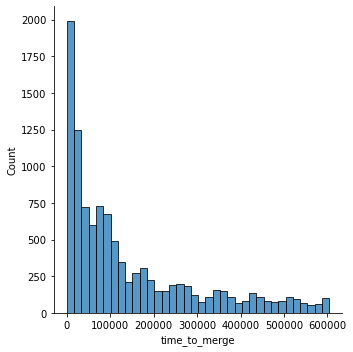

In [6]:
# time to merge of all times less than a week

to_plot = ttm_dataset[ttm_dataset.time_to_merge < 7 * 24 * 60 * 60]

g = sns.displot(to_plot.time_to_merge)

Often when describing the amount of time it takes for something to happen, we can talk about predicting a rate parameter, $\lambda$. This rate parameter describes the average amount of time for an event to occur. This is motivated by the [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution), the amount of time between events in a Poisson process. Given an input $X_i$, we wish to predict the rate parameter, $\lambda_i | X_i$. Often it makes sense to look at $\log Y_i$ to get a prediction for $\log \lambda_i$. This is because exponential data is very heavily skewed right. With data so heavily skewed we cannot perform meaningful regression since a model will be strongly penalized for predicting a very large time to merge. On the other hand, it will barely be penalized for way underpredicting the time to merge. Intuititvely, we would like the penalty for overpredicting the time to merge by $2$ times the actual time to stay the same whether the time to merge is small or large.

We visualize the log transformed data.

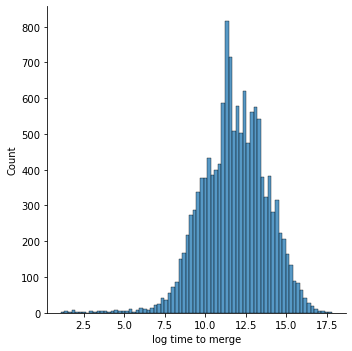

In [7]:
ax = sns.displot(np.log(ttm_dataset.time_to_merge))

ax.set(xlabel="log time to merge")

Now we get data that somewhat resembles a normal distribution! When doing regression problems normal distributions are almost always preferable due to their very neat properties, especially symmetry.

## Preprocessing

In [8]:
# extract X and y from dataset
X = ttm_dataset.drop(columns=["ttm_class", "time_to_merge"])
y = np.log(ttm_dataset["time_to_merge"])

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
# lets apply a yeo johnson transform to try to make the data more gaussian
scaler = PowerTransformer()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Compare log regression and classification

We are going to train some standard models to find which performs the best. We will closely mimic the models used in the current model training notebook.

In [23]:
def train_evaluate(clf, xtrain, ytrain, xtest, ytest, kind="r"):
    # Train our classifier, 'r' is for regression, 'c' is for classification
    ytest = np.exp(ytest) / 3600
    if kind == "r":
        clf.fit(xtrain, ytrain)
        preds = np.exp(clf.predict(xtest)) / 3600
        preds = np.array([get_ttm_class(xi) for xi in preds])
        ytest = np.array([get_ttm_class(xi) for xi in ytest])
    else:
        ytrain = np.array([get_ttm_class(np.exp(yi) / 3600) for yi in ytrain])
        ytest = np.array([get_ttm_class(yi) for yi in ytest])
        clf.fit(xtrain, ytrain)
        preds = clf.predict(xtest)

    # View classification report
    print(classification_report(ytest, preds))

    # Plot confusion matrix heatmap
    plt.figure(figsize=(16, 12))
    cf_matrix = confusion_matrix(ytest, preds)
    group_counts = ["{0:0.0f}\n".format(value) for value in cf_matrix.flatten()]
    group_percentages = [
        "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
    ]
    box_labels = [
        f"{v1}{v2}".strip() for v1, v2 in zip(group_counts, group_percentages)
    ]
    box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

    sns.heatmap(cf_matrix, cmap="OrRd", annot=box_labels, fmt="")
    plt.xlabel("Predicted TTM Label")
    plt.ylabel("True TTM Label")
    plt.title("Confusion Matrix Heatmap")

### Random Forest

In [24]:
rfr = RandomForestRegressor(
    n_estimators=200,
    max_features=0.75,
    random_state=42,
    n_jobs=-1,
)

rfc = RandomForestClassifier(
    n_estimators=200,
    max_features=0.75,
    random_state=42,
    n_jobs=-1,
)

              precision    recall  f1-score   support

           0       0.56      0.09      0.15       249
           1       0.06      0.02      0.03       217
           2       0.20      0.21      0.21       364
           3       0.12      0.19      0.15       240
           4       0.12      0.19      0.15       275
           5       0.13      0.30      0.18       236
           6       0.15      0.23      0.18       333
           7       0.12      0.11      0.11       270
           8       0.19      0.07      0.10       260
           9       0.75      0.02      0.04       262

    accuracy                           0.15      2706
   macro avg       0.24      0.14      0.13      2706
weighted avg       0.24      0.15      0.13      2706



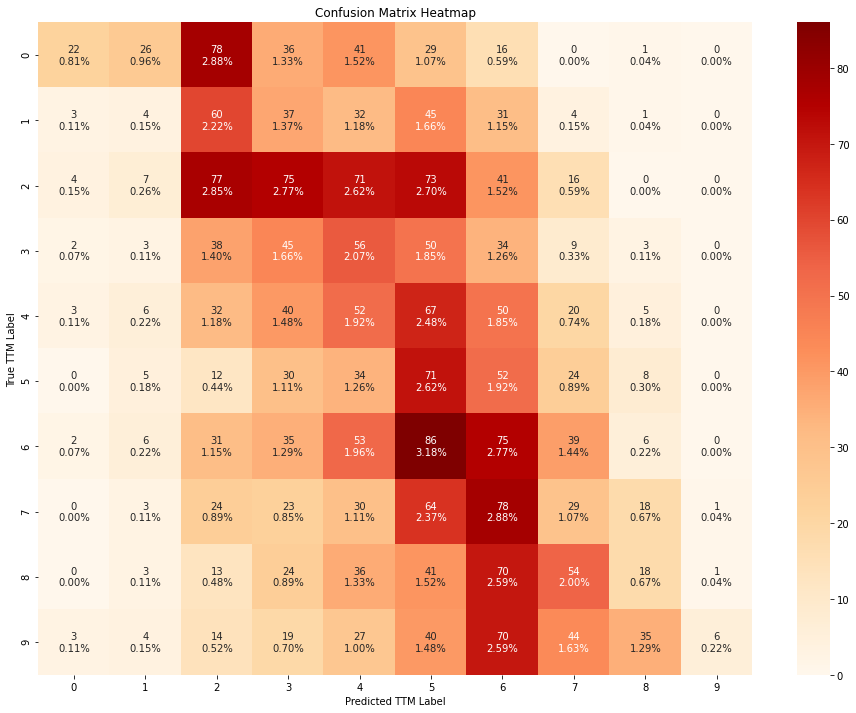

In [25]:
train_evaluate(rfr, X_train, y_train, X_test, y_test, kind="r")

              precision    recall  f1-score   support

           0       0.29      0.41      0.34       249
           1       0.13      0.10      0.11       217
           2       0.23      0.27      0.25       364
           3       0.15      0.16      0.16       240
           4       0.15      0.11      0.13       275
           5       0.11      0.09      0.10       236
           6       0.23      0.24      0.23       333
           7       0.18      0.15      0.16       270
           8       0.17      0.16      0.16       260
           9       0.24      0.28      0.26       262

    accuracy                           0.20      2706
   macro avg       0.19      0.20      0.19      2706
weighted avg       0.19      0.20      0.20      2706



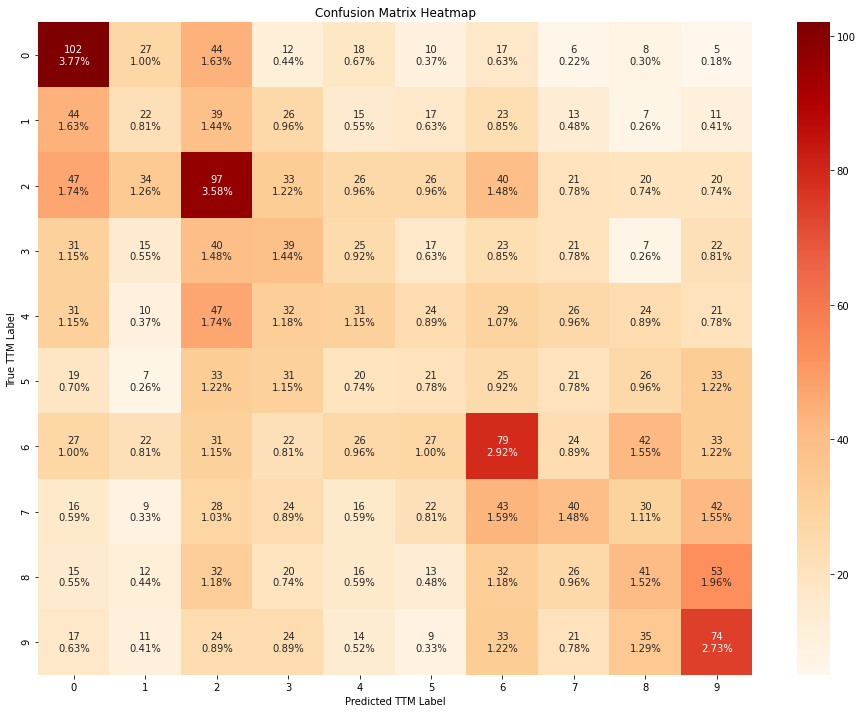

In [26]:
train_evaluate(rfc, X_train, y_train, X_test, y_test, kind="c")

The difference in how the regression vs. classification models work becomes very apparent here. The regression model is closely packed closer to the middle, and each class has a median class predicted with some spread. However, it is very hesitant to predict the outlier classes of 0 and 9.

### XGBoost

In [27]:
xgbr = XGBRegressor(
    n_estimators=125,
    learning_rate=0.1,
    random_state=42,
    verbosity=1,
    n_jobs=-1,
)

xgbc = XGBClassifier(
    n_estimators=125,
    learning_rate=0.1,
    random_state=42,
    verbosity=1,
    n_jobs=-1,
)

              precision    recall  f1-score   support

           0       0.59      0.08      0.14       249
           1       0.19      0.05      0.07       217
           2       0.23      0.26      0.24       364
           3       0.14      0.21      0.17       240
           4       0.16      0.25      0.19       275
           5       0.13      0.29      0.18       236
           6       0.18      0.26      0.21       333
           7       0.12      0.11      0.12       270
           8       0.23      0.10      0.14       260
           9       0.42      0.02      0.04       262

    accuracy                           0.17      2706
   macro avg       0.24      0.16      0.15      2706
weighted avg       0.24      0.17      0.16      2706



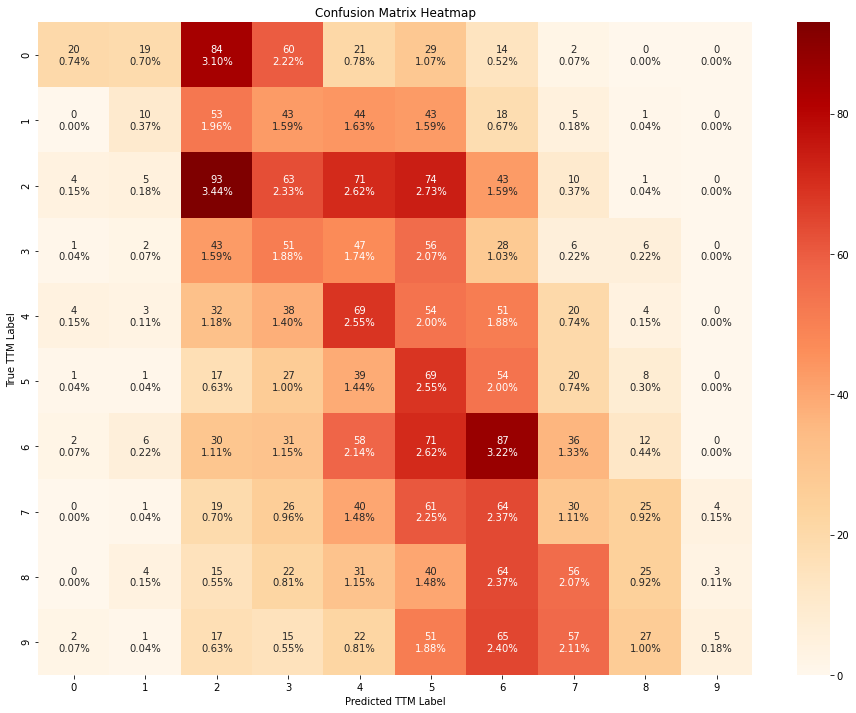

In [28]:
train_evaluate(xgbr, X_train, y_train, X_test, y_test, kind="r")

              precision    recall  f1-score   support

           0       0.29      0.41      0.34       249
           1       0.13      0.10      0.11       217
           2       0.23      0.27      0.25       364
           3       0.15      0.16      0.16       240
           4       0.15      0.11      0.13       275
           5       0.11      0.09      0.10       236
           6       0.23      0.24      0.23       333
           7       0.18      0.15      0.16       270
           8       0.17      0.16      0.16       260
           9       0.24      0.28      0.26       262

    accuracy                           0.20      2706
   macro avg       0.19      0.20      0.19      2706
weighted avg       0.19      0.20      0.20      2706



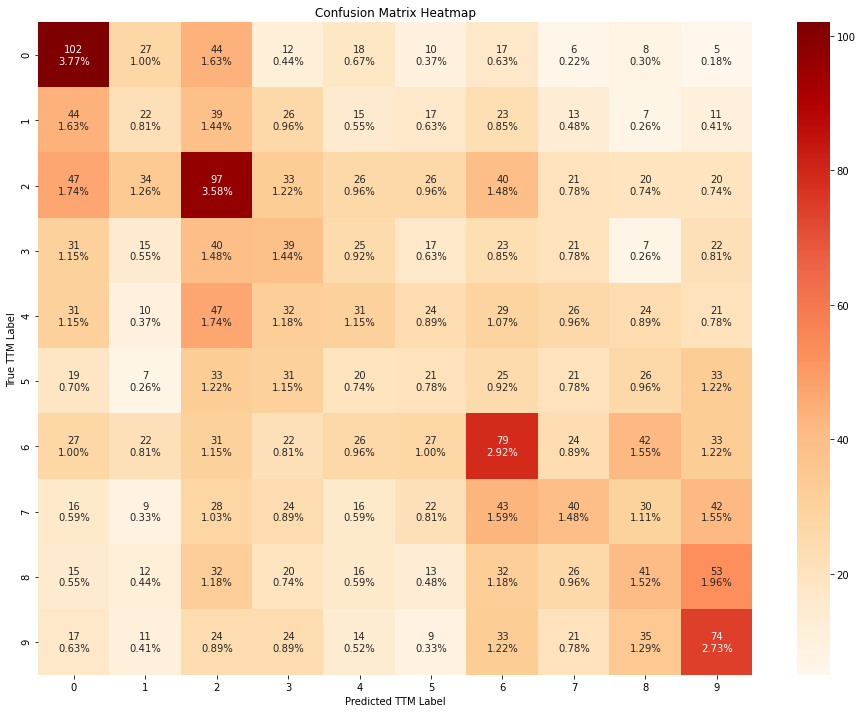

In [29]:
train_evaluate(rfc, X_train, y_train, X_test, y_test, kind="c")

# Analysis of regression

We now compare the random forest and gradient boost regression models. We plot the scatterplots of predicted vs. actual log time to merge values.

In [30]:
model1 = RandomForestRegressor(
    n_estimators=200,
    max_features=0.75,
    random_state=42,
    n_jobs=-1,
)

model2 = XGBRegressor(
    n_estimators=125,
    learning_rate=0.1,
    random_state=42,
    verbosity=1,
    n_jobs=-1,
)

MSE: 3.06145513923558
R^2: 0.19964350767594508


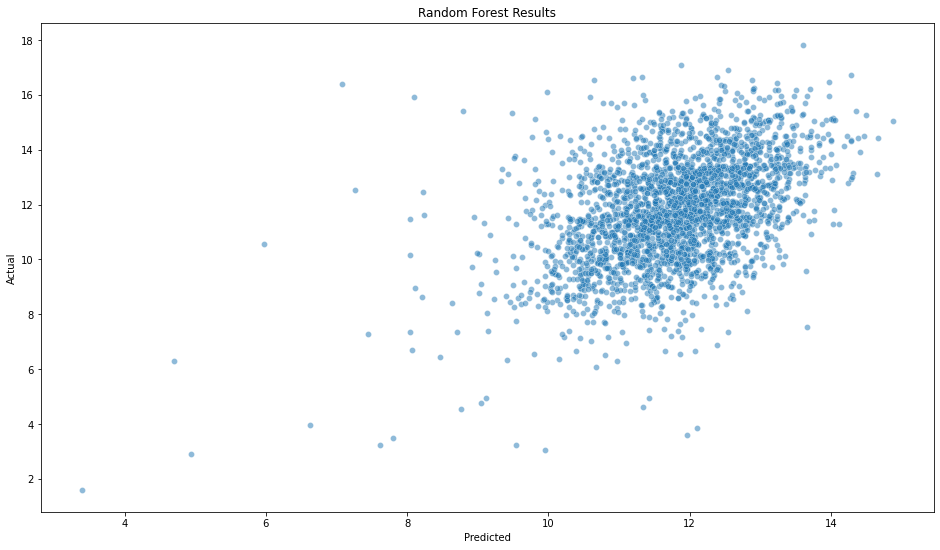

In [31]:
model = model1
model.fit(X_train, y_train)
preds = model.predict(X_test)

mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"MSE: {mse}")
print(f"R^2: {r2}")

fig, ax = plt.subplots(figsize=(16, 9))
p = sns.scatterplot(x=preds, y=y_test, alpha=0.5, ax=ax)

p.set_xlabel("Predicted")
p.set_ylabel("Actual")
output = p.set_title("Random Forest Results")

MSE: 2.9563846748298297
R^2: 0.22711208863305254


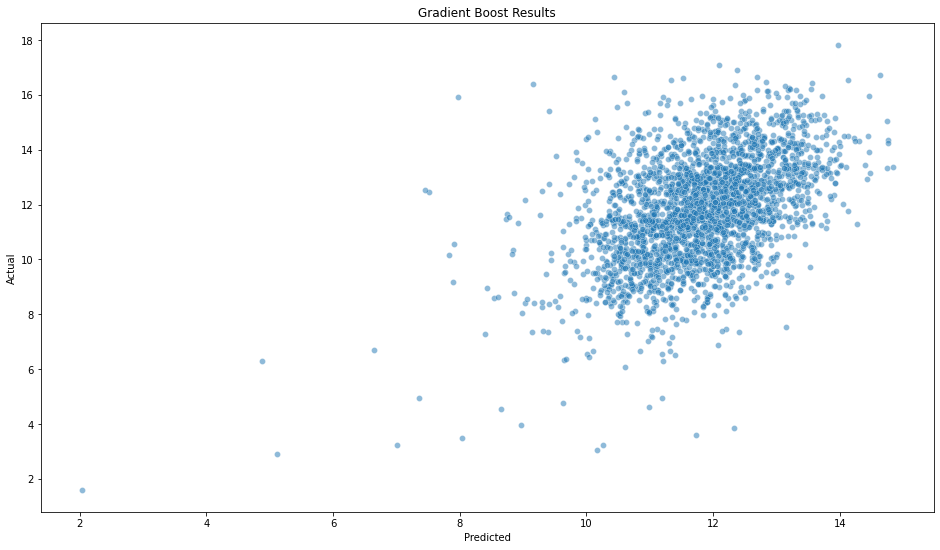

In [32]:
model = model2
model.fit(X_train, y_train)
preds = model.predict(X_test)

mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"MSE: {mse}")
print(f"R^2: {r2}")

fig, ax = plt.subplots(figsize=(16, 9))
p = sns.scatterplot(x=preds, y=y_test, alpha=0.5, ax=ax)

p.set_xlabel("Predicted")
p.set_ylabel("Actual")
output = p.set_title("Gradient Boost Results")

We can clearly see that there is a linear trend between the predicted and actual values for both models. Note that this is predicting the log of the number of seconds to merge. As in the classification models, since random forests are easier to use with seldon and sklearn, and it performs about as well as the gradient boost model, the random forest will be the model of choice.

## p-p plot

If we assume that each datapoint $x_i$ follows a exponential distribution with rate parameter $\lambda_i$, where we predict $\log \lambda_i = f(x_i)$, then for each prediction we make we have both an estimated mean and an estimated distribution that follows. For each datapoint, we can compute the probability of the datapoint falling in its place on the estimated distribution. If the model is doing a good job, and we are correct about our assumptions, then the probabilities would follow a uniform distribution.

In [33]:
def exponential_cdf(lambda_est, actual):
    return 1 - np.exp(-actual / lambda_est)


preds = model1.predict(X_test)
estimated = np.exp(preds)
actual = np.exp(y_test)

dpoints = [exponential_cdf(est, act) for est, act in zip(estimated, actual)]

uniform = np.arange(0, 1, 1 / len(dpoints))

We use a q-q plot to compare our results to the uniform distribution. The x-axis shows where the data point SHOULD be, and the y-axis shows what it actually is. If the distributions fit perfectly we would see a straight line.

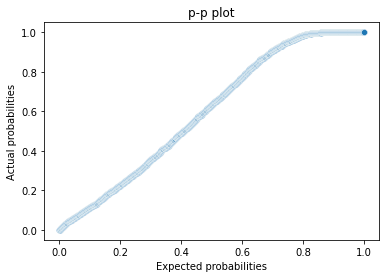

In [34]:
dpoints = sorted(dpoints)

p = sns.scatterplot(x=uniform, y=dpoints, alpha=1)
p.set_xlabel("Expected probabilities")
p.set_ylabel("Actual probabilities")
output = p.set_title("p-p plot")

Our line is fairly straight, but we can see that ~20% of our predictions were very unlikely if our assumptions were correct and our model was perfect.

What we can take away from this is that a log model is definitely a favorable model to look at as opposed to predicting the raw time to merge. Whether or not this is a "better model" is subjective, as it heavily depends on what we would want a user to get out of a time to merge prediction. Our f1 scores and accuracy scores are not as high as the classification model, but this is expected, as those are classification metrics and it is not really fair to compare a regression model to a classification model using classification metrics. The main benefit to the regression method is that it has a good linear pattern and picks up on the trend of what makes merging times longer. The drawback is that it is not good at predicting the edge cases of very long and very short times to merge, but the classification model does not seem to pick up on the trend.